## Import Libraries

In [306]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics

%matplotlib inline

## Load the Data

In [307]:
df = pd.read_csv("clear_data.csv")

In [308]:
df.shape

(6529, 18)

In [309]:
df.drop('Unnamed: 0', axis=1 ,inplace=True)


In [310]:
df.head(2)

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger
0,Manchester United,Defender Left-Back,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,4,35000000,42000000,2,1
1,Manchester United,Defender Left-Back,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,3,22000000,22000000,2,1


## Preprocess the Data

#### 1. Simple EDA + Data Quality checking

In [311]:
# uniqeness
df.drop_duplicates(inplace=True)
df[df.duplicated()]

,team,position,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,award,current_value,highest_value,position_encoded,winger


In [312]:
df['age']=df['age'].astype(int)
df['height'] = df['height'].astype(int)

In [313]:
# Accurecy - Outlier

# Convert categorical variables using OneHotEncoding
categorical_features = [ 'team','position']
numeric_features = ['height', 'age', 'appearance','goals', 'assists', 'yellow cards','second yellow cards', 'red cards', 'goals conceded','clean sheets', 'minutes played','days_injured','games_injured','award','current_value','highest_value','position_encoded','winger']

In [314]:
for i in categorical_features:
    print(df[i].value_counts())

team
Royal AM FC               30
Al-Batin FC               28
Gangwon FC                28
Daejeon Hana Citizen      28
Jeonbuk Hyundai Motors    28
                          ..
Swansea City              12
Manchester City           11
Paris Saint-Germain       11
Gaziantep FK               5
Hatayspor                  5
Name: count, Length: 374, dtype: int64
position
Attack Centre-Forward         1294
midfield-CentralMidfield      1106
midfield-DefensiveMidfield     867
Defender Left-Back             774
midfield-AttackingMidfield     745
Attack-RightWinger             695
Attack-LeftWinger              694
midfield-RightMidfield          97
midfield-LeftMidfield           97
Attack-SecondStriker            62
midfield                        58
Attack                          40
Name: count, dtype: int64


In [315]:
df.dtypes

team                 object
position             object
height                int64
age                   int64
appearance            int64
goals               float64
assists             float64
red cards           float64
clean sheets        float64
minutes played        int64
days_injured          int64
games_injured         int64
award                 int64
current_value         int64
highest_value         int64
position_encoded      int64
winger                int64
dtype: object

#### 2. Feature engineering

1. Feature scaling
2. Aggregation
3. One hot coding

In [316]:
categorical_features

['team', 'position']

In [317]:
# one hot coding
df = pd.get_dummies(df, columns=categorical_features)

In [318]:
df.shape

(6529, 401)

In [319]:
df.head(2)

,height,age,appearance,goals,assists,red cards,clean sheets,minutes played,days_injured,games_injured,...,position_Attack-LeftWinger,position_Attack-RightWinger,position_Attack-SecondStriker,position_Defender Left-Back,position_midfield,position_midfield-AttackingMidfield,position_midfield-CentralMidfield,position_midfield-DefensiveMidfield,position_midfield-LeftMidfield,position_midfield-RightMidfield
0,178,27,74,0.015374,0.169115,0.0,0.0,5854,443,70,...,False,False,False,True,False,False,False,False,False,False
1,169,23,89,0.012619,0.063096,0.0,0.0,7132,182,15,...,False,False,False,True,False,False,False,False,False,False


In [320]:
p35 = df['current_value'].quantile(0.35)
p75 = df['current_value'].quantile(0.75)

# Function to categorize prices
def categorize_price(price):
    if price < p35:
        return 'Cheap_Price'
    elif price < p75:
        return 'Good_Price'
    else:
        return 'High_Price'

# Apply the function to create a new column
df['player_price_category'] = df['current_value'].apply(categorize_price)

df.drop('current_value', axis=1, inplace=True)

# Verify the distribution of the new categories
print(df['player_price_category'].value_counts())

player_price_category
Good_Price     2639
Cheap_Price    2103
High_Price     1787
Name: count, dtype: int64


In [321]:
p35, p75


(500000.0, 3000000.0)

In [322]:
encoder = LabelEncoder()
df['player_price_category'] = encoder.fit_transform(df['player_price_category'])  

#### 3. Feature selection

In [323]:
numeric_df = df.select_dtypes(include=[np.number])
correlation = numeric_df.corr()
print(correlation['player_price_category'].sort_values(ascending=False))

player_price_category    1.000000
appearance               0.517344
highest_value            0.511614
minutes played           0.505380
award                    0.262643
games_injured            0.247788
days_injured             0.206966
assists                  0.186481
goals                    0.159883
height                   0.109882
age                      0.032689
position_encoded         0.031803
red cards               -0.013640
winger                  -0.023977
clean sheets                  NaN
Name: player_price_category, dtype: float64


In [324]:
# Set the correlation threshold
threshold = 0.25 # You can change this value based on your requirement

# Filter the correlations
# We use `abs()` for absolute value to consider both strong positive and negative correlations
selected_features = correlation[abs(correlation['player_price_category']) > threshold]['player_price_category'].index
selected_features

Index(['appearance', 'minutes played', 'award', 'highest_value',
       'player_price_category'],
      dtype='object')

In [325]:
selected_features = ['age', 'appearance', 'minutes played', 'player_price_category', 'highest_value', 'team_AFC Bournemouth', 'team_RC Strasbourg Alsace', 'team_Stade Rennais FC']

In [326]:
df = df[selected_features]
df.head()

,age,appearance,minutes played,player_price_category,highest_value,team_AFC Bournemouth,team_RC Strasbourg Alsace,team_Stade Rennais FC
0,27,74,5854,2,42000000,False,False,False
1,23,89,7132,2,22000000,False,False,False
2,22,34,2686,2,12000000,False,False,False
3,31,101,7928,2,80000000,False,False,False
4,26,76,4687,2,35000000,False,False,False


#### 4. Prepare train and test data

In [327]:
# Prepare data
X = df.drop(['player_price_category'], axis=1)
y = df['player_price_category']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    shuffle=True,
                                                    random_state=42)

# sacle the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [328]:
X.shape

(6529, 7)

## Buliding the Model

In [329]:
model = KNeighborsClassifier()


In [330]:
param_grid = {
    'n_neighbors': [2, 3, 4, 5, 6, 7,8,10,15]
}
grid_search = GridSearchCV(estimator=model,
                           param_grid=param_grid,
                           cv=5,
                           scoring='f1_macro', 
                           n_jobs=-1,
                           verbose=1)

In [331]:
grid_search.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [2, 3, 4, 5, 6, 7, 8, 10, 15]},
             scoring='f1_macro', verbose=1)

In [332]:
grid_search.best_params_


{'n_neighbors': 7}

## Train the Model

In [333]:
model = grid_search.best_estimator_


## Test the Model

In [334]:
y_pred = model.predict(X_test)


## Evaluating the Model 

In [335]:
base_model = round(df['player_price_category'].value_counts()[1]/df.shape[0]*100, 2)
base_model

40.42

In [336]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

0.27947932618683

In [337]:
y_pred_train = model.predict(X_train_scaled)
accuracy = accuracy_score(y_train, y_pred_train)
accuracy

0.8119854489756845

In [338]:
conf_matrix = confusion_matrix(y_test, y_pred)
conf_matrix

array([[  0,   0, 413],
       [  0,   0, 528],
       [  0,   0, 365]])

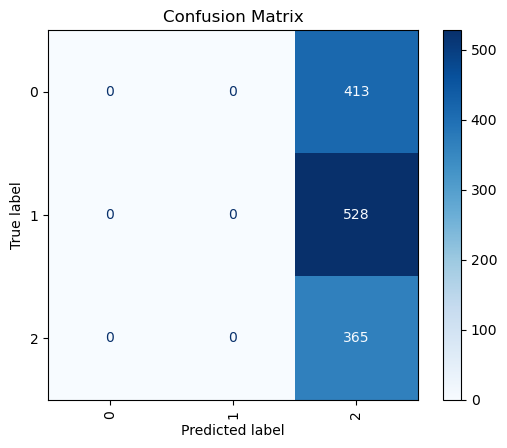

In [339]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(y_test, y_pred,
                                        display_labels=model.classes_,
                                        cmap="Blues",
                                        xticks_rotation='vertical')
plt.title('Confusion Matrix')
plt.show()

In [340]:
precision = precision_score(y_test, y_pred, average='macro')
print(f"Precision: {precision:.2f}")

Precision: 0.09


In [341]:
recall = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall:.2f}")

Recall: 0.33


In [342]:
f1 = f1_score(y_test, y_pred, average='macro')
print(f"F1 Score: {f1:.2f}")

F1 Score: 0.15
